***
# ***Geospatial Interpolation - GEOL5013A***
***

# ***Library Installations***

In [ ]:
!pip install geostatspy

# ***Imports***

## ***Library Imports***

In [ ]:
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as sp

# ***Directory Creation***

In [ ]:
# get working directory instance
current_path = os.getcwd()


# Set the path for the images directory
image_path = 'Images'
results_path = 'Results'

# Check if the images directory already exists
if not os.path.exists(image_path):
    # Create the images directory
    os.mkdir(image_path)
else:
    print('Image directory already exists')

# Check if the file directory already exists
if not os.path.exists(results_path):
    # Create the file directory
    os.mkdir(results_path)
else:
    print('File directory already exists')

print('Image directory is -', image_path)
print('File directory is -', results_path)


Image directory already exists
File directory already exists
Image directory is - Images
File directory is - Results


# ***Saving Images***

In [ ]:
# function to save the figure as images and pdfs
def image_saver(image_name):

  # Save the image as a PNG at 300 DPI
  png_filename = f'{current_path}/{image_path}/{image_name}.png'
  plt.savefig(png_filename, dpi=300, format="png")

  # Save the image as a PDF
  pdf_filename = f'{current_path}/{image_path}/{image_name}.pdf'
  plt.savefig(pdf_filename, format="pdf")

  return

# ***Dataset***

In [ ]:
df = pd.read_csv(current_path+"/sample_data_MV_biased.csv")

In [ ]:
df = df.iloc[:, 1:]
df.head()

,X,Y,Facies,Porosity,Perm,AI
0,100.0,900.0,0.0,0.101319,1.996868,5590.417154
1,100.0,800.0,1.0,0.147676,10.711789,3470.845666
2,100.0,700.0,1.0,0.145912,17.818143,3586.988513
3,100.0,600.0,1.0,0.186167,217.109365,3732.114787
4,100.0,500.0,1.0,0.146088,16.717367,2534.551236


In [ ]:
df.describe().transpose()                          # basic stats of dataset

,count,mean,std,min,25%,50%,75%,max
X,368.0,499.565217,289.770794,0.000000,240.000000,500.000000,762.500000,990.000000
Y,368.0,520.644022,277.412187,9.000000,269.000000,539.000000,769.000000,999.000000
Facies,368.0,0.597826,0.491004,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,368.0,0.127026,0.030642,0.041122,0.103412,0.125842,0.148623,0.210258
Perm,368.0,85.617362,228.362654,0.094627,2.297348,10.377292,50.581288,1991.097723
AI,368.0,4791.736646,974.560569,1981.177309,4110.728374,4713.325533,5464.043562,7561.250336


***
# ***Inverse Distance Weighing***
***

In [ ]:
# function for inverse distance weighing
def invdist(df, xcol, ycol, vcol, tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power):
    """
    Inverse Distance to Python by Michael Pyrcz, the University of Texas at
    Austin (April, 2020). Based on modification of the GSLIB kb2d program by Deutsch and Journel (1997)

    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :param ndmin: minimum number of data points to use for kriging a block
    :param ndmax: maximum number of data points to use for kriging a block
    :param radius: maximum isotropic search radius
    :param power: the inverse distance power
    :return: estmap, an array with estimated values at each grid cell
    """
    # Constants
    UNEST = -999.
    EPSILON = 1.0e-10

    # Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]  # Trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax, nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values

    # Allocate the needed memory:
    xa = np.zeros(ndmax)
    ya = np.zeros(ndmax)
    vra = np.zeros(ndmax)
    dist = np.zeros(ndmax)
    nums = np.zeros(ndmax)
    s = np.zeros(ndmax)
    estmap = np.zeros((nx, ny))

    # Make a KDTree for fast search of nearest neighbors
    data_locs = np.column_stack((y, x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)

    # Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    ss = stdev**2.0
    vrmin = vr.min()
    vrmax = vr.max()

    # Initialize accumulators
    rad2 = radius**2

    # MAIN LOOP OVER ALL THE BLOCKS IN THE GRID
    nk = 0
    ak = 0.0
    vk = 0.0
    for iy in range(0, ny):
        yloc = ymn + (iy - 0) * ysiz
        for ix in range(0, nx):
            xloc = xmn + (ix - 0) * xsiz
            current_node = (yloc, xloc)

            # Find the nearest samples within each octant: First initialize the counter arrays
            na = -1  # Accounting for 0 as the first index
            dist.fill(1.0e+20)
            nums.fill(-1)
            dist, nums = tree.query(current_node, ndmax)  # Use KD tree for fast nearest data search

            # Remove any data outside search radius
            nums = nums[dist < radius]
            dist = dist[dist < radius]
            nd = len(dist)

            # Is there enough samples?
            if nd < ndmin:  # Accounting for min index of 0
                est = UNEST
            else:
                # Put coordinates and values of neighborhood samples into xa, ya, vra
                for ia in range(0, nd):
                    jj = int(nums[ia])
                    xa[ia] = x[jj]
                    ya[ia] = y[jj]
                    vra[ia] = vr[jj]

                # Solve for weights
                dist = np.sqrt((xa - xloc)**2 + (ya - yloc)**2)
                s = 1 / ((dist + EPSILON)**power)  # Calculate inverse weights
                s = s / np.sum(s)  # Constrain sum of the weights to 1.0 for unbiasedness
                est = 0.0
                for ia in range(0, nd):
                    est = est + s[ia] * vra[ia]

            estmap[ny - iy - 1, ix] = est

            # Track the estimates
            if est > UNEST:
                nk = nk + 1
                ak = ak + est
                vk = vk + est**2

    # END OF MAIN LOOP OVER ALL THE BLOCKS

    if nk >= 1:
        ak = ak / float(nk)
        vk = vk / float(nk) - ak**2
        print('Estimated ' + str(nk) + ' blocks')
        print('Average ' + str(ak) + '  Variance ' + str(vk))

    return estmap


Estimated 10000 blocks
Average 0.12259182482534683  Variance 0.0005453274134406098


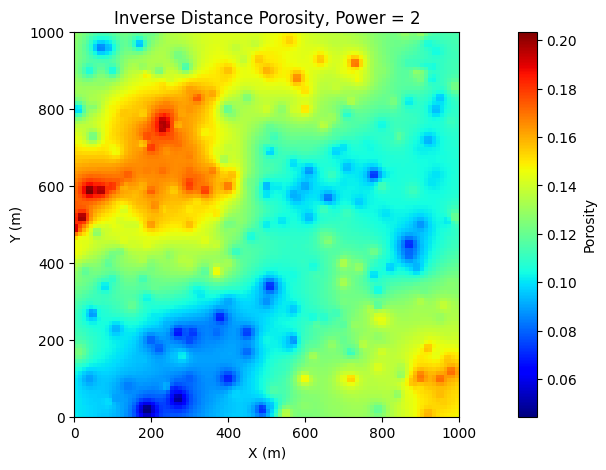

Estimated 10000 blocks
Average 0.12116877653698746  Variance 0.0007154759122327669


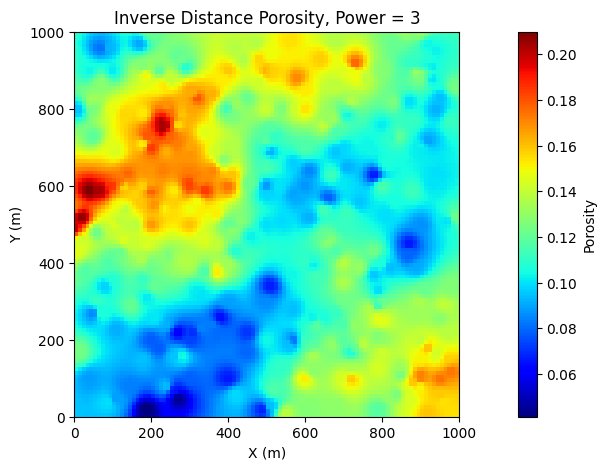

In [ ]:
# Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
radius = 2000
power = [2, 3]

for power_level in power:
  # Calculate the estimated map
  invdist_map_porosity = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power_level)

  # Plot the resulting estimated map
  plt.figure(figsize=(15, 5))
  plt.imshow(invdist_map_porosity, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap='jet')
  plt.colorbar(label='Porosity')
  plt.title(f'Inverse Distance Porosity, Power = {power_level}')
  plt.xlabel('X (m)')
  plt.ylabel('Y (m)')

  # saving the figure
  image_saver(f'IDW Porosity, Power = {power_level}')

  # preparing data for exportation by flattening them into 1D arrays
  X, Y = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny))
  flat_invdist_map = invdist_map_porosity.flatten()
  flat_X = X.flatten()
  flat_Y = Y.flatten()

  # forming a temporary dataframe to export the data
  temp_df = pd.DataFrame(
                         {
                          "X" : flat_X,
                         "Y": flat_Y,
                         "Porosity": flat_invdist_map
                          }
                         )

  # Save the results as a CSV file
  csv_filename = f"{current_path}/{results_path}/IDW Porosity results, Power = {power_level}.csv"
  temp_df.to_csv(csv_filename, index=False)

  plt.show()


# ***Import and Scatter Plot***

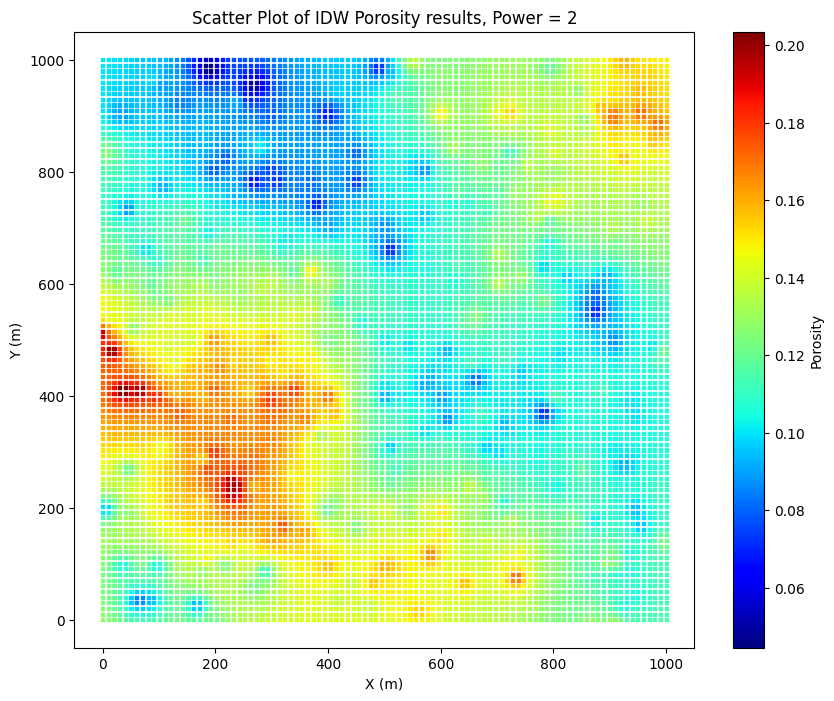

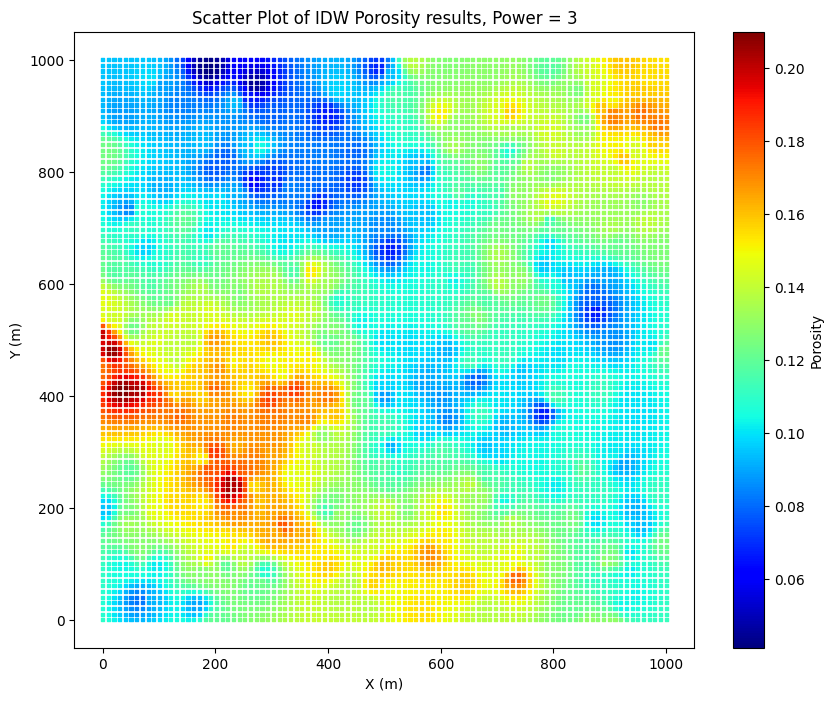

In [ ]:
# importing the data for IDW porosity results with Power = [2, 3]
p2_df = pd.read_csv(f'{current_path}/{results_path}/IDW Porosity results, Power = 2.csv')
p3_df = pd.read_csv(f'{current_path}/{results_path}/IDW Porosity results, Power = 3.csv')


# create a scatter plot for Power = 2
plt.figure(figsize=(10, 8))
plt.scatter(p2_df["X"], p2_df["Y"], c=p2_df["Porosity"], cmap='jet', s=5, marker='s')
plt.colorbar(label='Porosity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Scatter Plot of IDW Porosity results, Power = 2')

# saving figure
image_saver('Scatter Plot of IDW Porosity results, Power = 2')

# create a scatter plot for Power = 3
plt.figure(figsize=(10, 8))
plt.scatter(p3_df["X"], p3_df["Y"], c=p3_df["Porosity"], cmap='jet', s=5, marker='s')
plt.colorbar(label='Porosity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Scatter Plot of IDW Porosity results, Power = 3')

# saving figure
image_saver('Scatter Plot of IDW Porosity results, Power = 3')

plt.show()


# ***Kriging Results Export***

  Estimated   10000 blocks 
      average   0.11987661843262529  variance  0.0007842852670256004


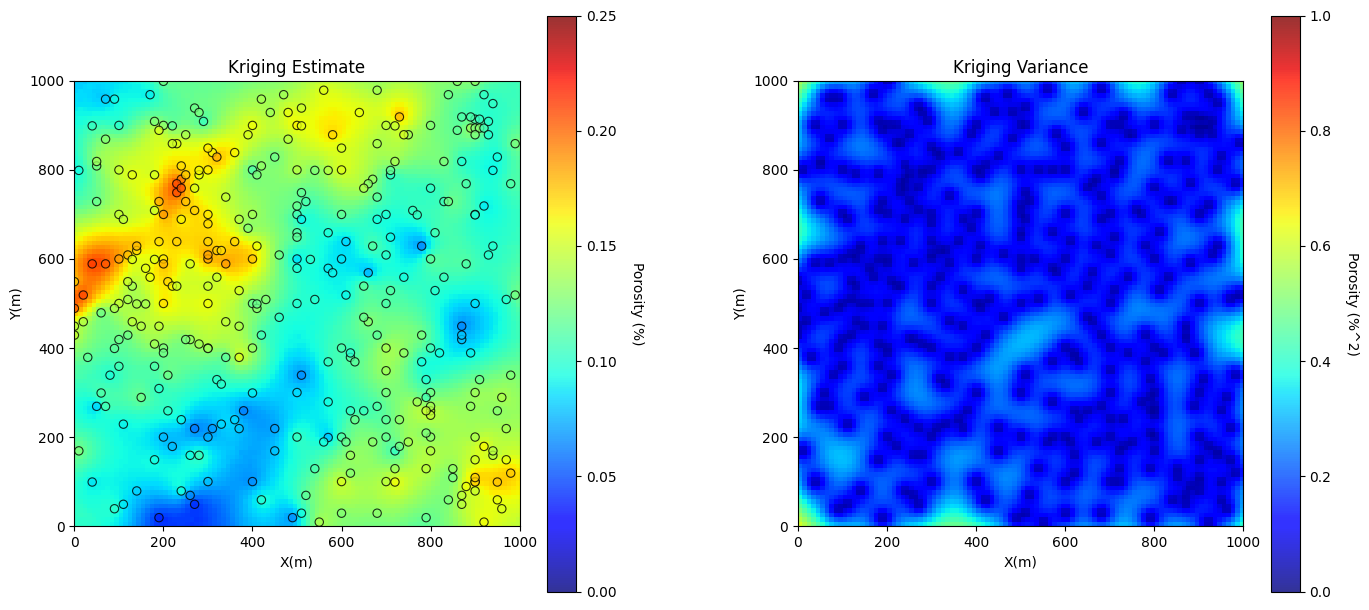

In [ ]:
# parameters
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values

xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

skmean_por = 0.10      # simple kriging mean (used if simple kriging is selected below)
ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
radius = 300                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 40                      # minimum and maximum data for an estimate
tmin = 0                                 # minimum property value
tmax = 999                                # maximum property value
por_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45,hmaj1=300,hmin1=300) # porosity variogram


# performing the Kriging estimation
por_kmap, por_vmap = geostats.kb2d(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,por_vario)

# plotting the krging results
plt.subplot(121)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap='jet')

plt.subplot(122)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap='jet')


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

# preparing to export the data by flattening it to 1D arrays
X, Y = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny))
por_kmap_flat = por_kmap.flatten()
por_vmap_flat = por_vmap.flatten()
flat_X = X.flatten()
flat_Y = Y.flatten()

# creating a temporary dataframe to export data
temp_df = pd.DataFrame(
                         {
                          "X" : flat_X,
                         "Y": flat_Y,
                         "por_kmap": por_kmap_flat,
                         'por_vmap': por_vmap_flat
                          }
                         )

# saving the results as a CSV file
csv_filename = f"{current_path}/{results_path}/kriging_results.csv"
temp_df.to_csv(csv_filename, index=False)

plt.show()

# ***Kriging Efficiency Calculation***

In [ ]:
# creating a function to calculate the Kriging efficiency

def KEFF(property_variance):
  block_variance = 1
  KEFF = (block_variance - property_variance)/block_variance

  return  KEFF


In [ ]:
temp_df['KEFF'] = temp_df['por_vmap'].apply(KEFF)   # creating a column to store the Kriging efficiency for each row
temp_df.head()

,X,Y,por_kmap,por_vmap,KEFF
0,0.00000,0.0,0.082577,0.549151,0.450849
1,10.10101,0.0,0.082118,0.504822,0.495178
2,20.20202,0.0,0.081773,0.459172,0.540828
3,30.30303,0.0,0.084060,0.412179,0.587821
4,40.40404,0.0,0.084781,0.368353,0.631647


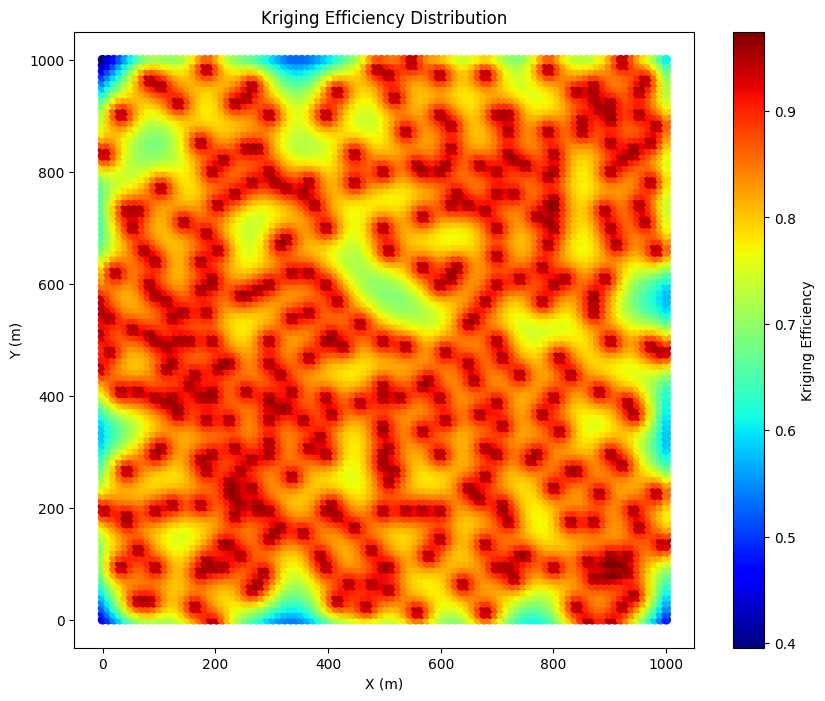

In [ ]:
# plotting the Kriging efficiency distribution
plt.figure(figsize=(10, 8))
scatter = plt.scatter(temp_df["X"], temp_df['Y'], c=temp_df['KEFF'], cmap='jet')
plt.colorbar(scatter, label='Kriging Efficiency')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Kriging Efficiency Distribution')
plt.show()


# ***Interpolation Method Comparison***


Looking at the average and variance values for each method:

- **IDW Power = 2**: Average = 0.12259, Variance = 0.000545
- **IDW Power = 3**: Average = 0.12117, Variance = 0.000715
- **Kriging**: Average = 0.11988, Variance = 0.000784

From these values, it can be deduced that IDW with a power of 2 has the lowest variance, indicating that the predictions are more consistent across the estimated grid blocks. The IDW with power of 3 has a lower average value but a higher variance. From this we can see that a higher power might have a lower average, but with a high variance. Somewhat almost as if it will approach the Kriging predictions.
Kriging has a lower average and a higher variance ( this might due to natural variablity of data since it is modelled using a variogram) compared to the first two IDW methods. From this I would say Kriging is a better interpolation method.

Comparing both methods, Kriging uses a variogram to model spatial correlation, thereby allowing it to make more informed predictions through the consideration of the spatial arrangement of data points. IDW assumes that points closer to the prediction location exert greater influence than those farther away, it does not explicitly model spatial correlation. Furthermore, Kriging is expected to reproduce the measured values at sample points in its predictions, whereas IDW may not perfectly replicate these values due to the impact of proximal points.
